In [ ]:
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score

from utils.data import read_dataset
from utils.image_preprocessing import preprocess_dataset
from utils.hyperparameter_optimizer import optimize_hyperparameters

from feature_extraction.extract_features import extract

%matplotlib inline

# Loading data

In [ ]:
X_raw, y = read_dataset('./data/rockpaperscissors/augmented_data')
X = preprocess_dataset(X_raw, image_shape=(300,200))

In [3]:
X.shape

(8752, 60000)

In [4]:
TRAIN_SIZE = int(0.8 * y.shape[0])
X_train, y_train = X[:TRAIN_SIZE], y[:TRAIN_SIZE]
X_test, y_test = X[TRAIN_SIZE:], y[TRAIN_SIZE:]

In [5]:
X_train.shape

(7001, 60000)

### Scaled images

In [6]:
X_scaled = preprocess_dataset(X_raw, image_shape=(150, 100))
X_scaled_train, X_scaled_test = X_scaled[:TRAIN_SIZE], X_scaled[TRAIN_SIZE:]

In [7]:
X_scaled.shape

(8752, 15000)

### PCA

In [6]:
pca_model = PCA(n_components=300)
X_pca = pca_model.fit_transform(X)

X_pca_train = X_pca[:TRAIN_SIZE]
X_pca_test = X_pca[TRAIN_SIZE:]

In [7]:
X_pca.shape

(8752, 300)

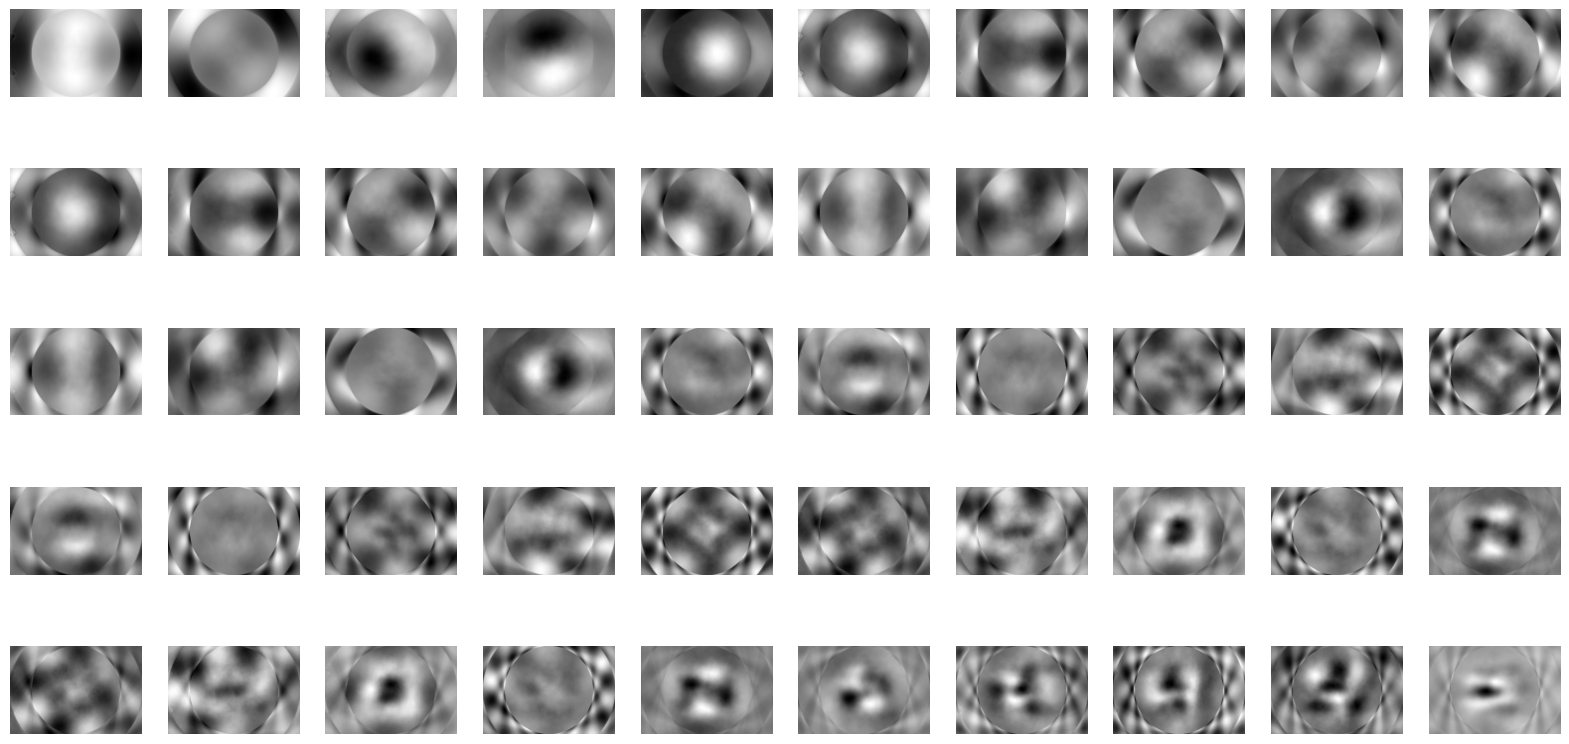

In [10]:
N,M = 5,10
fig, ax = plt.subplots(N, M, figsize=(20,10))
for i in range(N):
    for j in range(M):
        ax[i,j].imshow(pca_model.components_[N*i + j].reshape((200, 300)), cmap='gray')
        ax[i,j].axis('off')
plt.show()

### Feature extraction

In [ ]:
X_extracted = extract(images=X_raw)
X_extracted_train = X_extracted[:TRAIN_SIZE]
X_extracted_test = X_extracted[TRAIN_SIZE:]

In [7]:
X_extracted.shape

(8752, 4096)

# Training models

## Hyperparameter tuning

For each model we select hyperparameters that maximize mean accuracy measured by cross-validation on training set.

### KNN

#### Full images (needs huge RAM capacity)

In [11]:
# knn_result = optimize_hyperparameters('knn', X_train, y_train, n_trials=100)
# print(knn_result)

In [12]:
best_knn_model = KNeighborsClassifier(n_jobs=-1, n_neighbors=3)
best_knn_model.fit(X_train, y_train)
best_knn_model.score(X_test, y_test)

0.712164477441462

#### Scaled images

In [13]:
knn_scaled_result = optimize_hyperparameters('knn', X_scaled_train, y_train, n_trials=100)
print(knn_scaled_result)

[I 2024-02-10 00:27:40,080] A new study created in memory with name: no-name-bd70f1bf-628b-4cb9-a044-bb9b2526ff22
[I 2024-02-10 00:27:57,178] Trial 5 finished with value: 0.6571883024251071 and parameters: {'n_neighbors': 15}. Best is trial 5 with value: 0.6571883024251071.
[I 2024-02-10 00:28:02,609] Trial 0 finished with value: 0.6631866721010801 and parameters: {'n_neighbors': 12}. Best is trial 0 with value: 0.6631866721010801.
[I 2024-02-10 00:28:02,709] Trial 1 finished with value: 0.6177658447116363 and parameters: {'n_neighbors': 32}. Best is trial 0 with value: 0.6631866721010801.
[I 2024-02-10 00:28:21,735] Trial 4 finished with value: 0.6913260648053801 and parameters: {'n_neighbors': 3}. Best is trial 4 with value: 0.6913260648053801.
[I 2024-02-10 00:28:25,716] Trial 2 finished with value: 0.635190544120644 and parameters: {'n_neighbors': 24}. Best is trial 4 with value: 0.6913260648053801.
[I 2024-02-10 00:28:31,434] Trial 6 finished with value: 0.6187636030160995 and par

FrozenTrial(number=4, state=1, values=[0.6913260648053801], datetime_start=datetime.datetime(2024, 2, 10, 0, 27, 40, 85892), datetime_complete=datetime.datetime(2024, 2, 10, 0, 28, 21, 735501), params={'n_neighbors': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=49, log=False, low=3, step=1)}, trial_id=4, value=None)


In [14]:
knn_scaled_result.params

{'n_neighbors': 3}

In [15]:
knn_scaled_result.value

0.6913260648053801

In [16]:
best_knn_model_scaled = KNeighborsClassifier(n_jobs=-1, **knn_scaled_result.params)

knn_score_scaled = cross_val_score(best_knn_model_scaled, X_scaled_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {knn_score_scaled.mean()}, std: {knn_score_scaled.std()}\n')

best_knn_model_scaled.fit(X_scaled_train, y_train)
print(f'test set: {best_knn_model_scaled.score(X_scaled_test, y_test)}')

cross validation:
mean: 0.6913260648053801, std: 0.015473457351054312

test set: 0.7167332952598515


#### PCA

In [17]:
knn_pca_result = optimize_hyperparameters('knn', X_pca_train, y_train, n_trials=100)
print(knn_pca_result)

[I 2024-02-10 00:35:54,686] A new study created in memory with name: no-name-a0520fa4-a87e-429f-b6d5-6c1e7f4d66a4
[I 2024-02-10 00:35:54,939] Trial 2 finished with value: 0.593912777664561 and parameters: {'n_neighbors': 40}. Best is trial 2 with value: 0.593912777664561.
[I 2024-02-10 00:35:55,153] Trial 0 finished with value: 0.6021964540452416 and parameters: {'n_neighbors': 36}. Best is trial 0 with value: 0.6021964540452416.
[I 2024-02-10 00:35:55,282] Trial 5 finished with value: 0.6101952313022213 and parameters: {'n_neighbors': 31}. Best is trial 5 with value: 0.6101952313022213.
[I 2024-02-10 00:35:55,307] Trial 3 finished with value: 0.5834872630935399 and parameters: {'n_neighbors': 47}. Best is trial 5 with value: 0.6101952313022213.
[I 2024-02-10 00:35:55,504] Trial 8 finished with value: 0.6997546362339515 and parameters: {'n_neighbors': 3}. Best is trial 8 with value: 0.6997546362339515.
[I 2024-02-10 00:35:55,580] Trial 1 finished with value: 0.6061958426737315 and para

FrozenTrial(number=8, state=1, values=[0.6997546362339515], datetime_start=datetime.datetime(2024, 2, 10, 0, 35, 54, 697648), datetime_complete=datetime.datetime(2024, 2, 10, 0, 35, 55, 504705), params={'n_neighbors': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=49, log=False, low=3, step=1)}, trial_id=8, value=None)


In [18]:
knn_pca_result.params

{'n_neighbors': 3}

In [19]:
knn_pca_result.value

0.6997546362339515

In [20]:
best_knn_model_pca = KNeighborsClassifier(n_jobs=-1, **knn_pca_result.params)

knn_score_pca = cross_val_score(best_knn_model_pca, X_pca_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {knn_score_pca.mean()}, std: {knn_score_pca.std()}\n')

best_knn_model_pca.fit(X_pca_train, y_train)
print(f'test set: {best_knn_model_pca.score(X_pca_test, y_test)}')

cross validation:
mean: 0.6997546362339515, std: 0.012507660271671566

test set: 0.7252998286693318


#### Extracted features

In [8]:
knn_extracted_result = optimize_hyperparameters('knn', X_extracted_train, y_train, n_trials=100)
print(knn_extracted_result)

[I 2024-02-10 15:15:01,269] A new study created in memory with name: no-name-d1b8bb2c-f32c-40c5-bd7f-0df019f7f604
[I 2024-02-10 15:15:11,416] Trial 4 finished with value: 0.9288667210108008 and parameters: {'n_neighbors': 25}. Best is trial 4 with value: 0.9288667210108008.
[I 2024-02-10 15:15:12,370] Trial 9 finished with value: 0.9298693702873446 and parameters: {'n_neighbors': 4}. Best is trial 9 with value: 0.9298693702873446.
[I 2024-02-10 15:15:13,158] Trial 1 finished with value: 0.9288667210108009 and parameters: {'n_neighbors': 29}. Best is trial 9 with value: 0.9298693702873446.
[I 2024-02-10 15:15:15,374] Trial 8 finished with value: 0.9244383533727328 and parameters: {'n_neighbors': 35}. Best is trial 9 with value: 0.9298693702873446.
[I 2024-02-10 15:15:16,189] Trial 5 finished with value: 0.9208667210108009 and parameters: {'n_neighbors': 41}. Best is trial 9 with value: 0.9298693702873446.
[I 2024-02-10 15:15:17,126] Trial 6 finished with value: 0.92158059914408 and para

FrozenTrial(number=37, state=1, values=[0.9357240676584471], datetime_start=datetime.datetime(2024, 2, 10, 15, 15, 41, 105185), datetime_complete=datetime.datetime(2024, 2, 10, 15, 15, 58, 409662), params={'n_neighbors': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=49, log=False, low=3, step=1)}, trial_id=37, value=None)


In [9]:
knn_extracted_result.params

{'n_neighbors': 10}

In [10]:
knn_extracted_result.value

0.9357240676584471

In [11]:
best_knn_model_extracted = KNeighborsClassifier(n_jobs=-1, **knn_extracted_result.params)

knn_score_extracted = cross_val_score(best_knn_model_extracted, X_extracted_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {knn_score_extracted.mean()}, std: {knn_score_extracted.std()}\n')

best_knn_model_extracted.fit(X_extracted_train, y_train)
print(f'test set: {best_knn_model_extracted.score(X_extracted_test, y_test)}')

cross validation:
mean: 0.9357240676584471, std: 0.009120434313379163

test set: 0.9411764705882353


### Decision Tree

#### PCA

In [21]:
decision_tree_pca_result = optimize_hyperparameters('decision_tree', X_pca_train, y_train, n_trials=500)
print(decision_tree_pca_result)

[I 2024-02-10 00:36:06,170] A new study created in memory with name: no-name-f7880ce0-4450-4452-b527-ce467b8b0b7f
[I 2024-02-10 00:36:07,949] Trial 0 finished with value: 0.5229245975137559 and parameters: {'max_depth': 26, 'min_samples_split': 30, 'min_samples_leaf': 4, 'max_leaf_nodes': 10}. Best is trial 0 with value: 0.5229245975137559.
[I 2024-02-10 00:36:08,121] Trial 2 finished with value: 0.4057996739351946 and parameters: {'max_depth': 2, 'min_samples_split': 14, 'min_samples_leaf': 18, 'max_leaf_nodes': 27}. Best is trial 0 with value: 0.5229245975137559.
[I 2024-02-10 00:36:08,542] Trial 1 finished with value: 0.4057996739351946 and parameters: {'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_leaf_nodes': 16}. Best is trial 0 with value: 0.5229245975137559.
[I 2024-02-10 00:36:09,189] Trial 7 finished with value: 0.40622783778275934 and parameters: {'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_leaf_nodes': 3}. Best is trial 0 with 

FrozenTrial(number=294, state=1, values=[0.5699203179131852], datetime_start=datetime.datetime(2024, 2, 10, 0, 43, 27, 869801), datetime_complete=datetime.datetime(2024, 2, 10, 0, 43, 46, 359079), params={'max_depth': 14, 'min_samples_split': 24, 'min_samples_leaf': 9, 'max_leaf_nodes': 30}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=30, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=40, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1), 'max_leaf_nodes': IntDistribution(high=30, log=False, low=3, step=1)}, trial_id=294, value=None)


In [22]:
decision_tree_pca_result.params

{'max_depth': 14,
 'min_samples_split': 24,
 'min_samples_leaf': 9,
 'max_leaf_nodes': 30}

In [23]:
decision_tree_pca_result.value

0.5699203179131852

In [24]:
best_decision_tree_model_pca = DecisionTreeClassifier(**decision_tree_pca_result.params)

decision_tree_score_pca = cross_val_score(best_decision_tree_model_pca, X_pca_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {decision_tree_score_pca.mean()}, std: {decision_tree_score_pca.std()}\n')

best_decision_tree_model_pca.fit(X_pca_train, y_train)
print(f'test set: {best_decision_tree_model_pca.score(X_pca_test, y_test)}')

cross validation:
mean: 0.5699203179131852, std: 0.023943830507767227

test set: 0.5968018275271274


#### Extracted features

In [7]:
decision_tree_extracted_result = optimize_hyperparameters('decision_tree', X_extracted_train, y_train, n_trials=50)
print(decision_tree_extracted_result)

[I 2024-02-10 15:26:11,517] A new study created in memory with name: no-name-9cfe7300-4c28-4d58-a9a7-c2acc311af1c
[I 2024-02-10 15:26:33,219] Trial 9 finished with value: 0.7860330140615447 and parameters: {'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_leaf_nodes': 24}. Best is trial 9 with value: 0.7860330140615447.
[I 2024-02-10 15:26:44,706] Trial 7 finished with value: 0.7718905644996943 and parameters: {'max_depth': 10, 'min_samples_split': 26, 'min_samples_leaf': 10, 'max_leaf_nodes': 18}. Best is trial 9 with value: 0.7860330140615447.
[I 2024-02-10 15:26:49,260] Trial 11 finished with value: 0.6857631954350928 and parameters: {'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_leaf_nodes': 4}. Best is trial 9 with value: 0.7860330140615447.
[I 2024-02-10 15:26:49,732] Trial 3 finished with value: 0.7608936213572448 and parameters: {'max_depth': 22, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_leaf_nodes': 14}. Best is trial 9 wi

FrozenTrial(number=28, state=1, values=[0.7900324026900346], datetime_start=datetime.datetime(2024, 2, 10, 15, 27, 43, 651808), datetime_complete=datetime.datetime(2024, 2, 10, 15, 28, 36, 261857), params={'max_depth': 17, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_leaf_nodes': 30}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=30, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=40, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1), 'max_leaf_nodes': IntDistribution(high=30, log=False, low=3, step=1)}, trial_id=28, value=None)


In [8]:
decision_tree_extracted_result.params

{'max_depth': 17,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 30}

In [9]:
decision_tree_extracted_result.value

0.7900324026900346

In [10]:
best_decision_tree_model_extracted = DecisionTreeClassifier(**decision_tree_extracted_result.params)

decision_tree_score_extracted = cross_val_score(best_decision_tree_model_extracted, X_extracted_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {decision_tree_score_extracted.mean()}, std: {decision_tree_score_extracted.std()}\n')

best_decision_tree_model_extracted.fit(X_extracted_train, y_train)
print(f'test set: {best_decision_tree_model_extracted.score(X_extracted_test, y_test)}')

cross validation:
mean: 0.7900324026900346, std: 0.014001476964203964

test set: 0.7961165048543689


### Random Forest

#### PCA

In [25]:
random_forest_pca_result = optimize_hyperparameters('random_forest', X_pca_train, y_train, n_trials=100)
print(random_forest_pca_result)

[I 2024-02-10 00:49:12,375] A new study created in memory with name: no-name-bceb6606-eec0-4fae-b8d9-f0cd172bf3af
[I 2024-02-10 00:49:30,747] Trial 2 finished with value: 0.7106119828815977 and parameters: {'n_estimators': 217, 'max_depth': 31, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_leaf_nodes': 31}. Best is trial 2 with value: 0.7106119828815977.
[I 2024-02-10 00:49:45,247] Trial 1 finished with value: 0.7053256572243733 and parameters: {'n_estimators': 246, 'max_depth': 7, 'min_samples_split': 38, 'min_samples_leaf': 13, 'max_leaf_nodes': 58}. Best is trial 2 with value: 0.7106119828815977.
[I 2024-02-10 00:50:03,583] Trial 0 finished with value: 0.7110381088241289 and parameters: {'n_estimators': 379, 'max_depth': 7, 'min_samples_split': 25, 'min_samples_leaf': 10, 'max_leaf_nodes': 68}. Best is trial 0 with value: 0.7110381088241289.
[I 2024-02-10 00:50:34,412] Trial 5 finished with value: 0.6766172814346851 and parameters: {'n_estimators': 463, 'max_depth': 38, 'min_

FrozenTrial(number=93, state=1, values=[0.7558899531281842], datetime_start=datetime.datetime(2024, 2, 10, 1, 45, 47, 667971), datetime_complete=datetime.datetime(2024, 2, 10, 1, 54, 51, 356796), params={'n_estimators': 645, 'max_depth': 48, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_leaf_nodes': 69}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=70, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=40, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1), 'max_leaf_nodes': IntDistribution(high=70, log=False, low=3, step=1)}, trial_id=93, value=None)


In [26]:
random_forest_pca_result.params

{'n_estimators': 645,
 'max_depth': 48,
 'min_samples_split': 17,
 'min_samples_leaf': 10,
 'max_leaf_nodes': 69}

In [27]:
random_forest_pca_result.value

0.7558899531281842

In [28]:
best_random_forest_model_pca = RandomForestClassifier(**random_forest_pca_result.params)

random_forest_score_pca = cross_val_score(best_random_forest_model_pca, X_pca_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {random_forest_score_pca.mean()}, std: {random_forest_score_pca.std()}\n')

best_random_forest_model_pca.fit(X_pca_train, y_train)
print(f'test set: {best_random_forest_model_pca.score(X_pca_test, y_test)}')

cross validation:
mean: 0.7564605665375993, std: 0.016229176423601374

test set: 0.7635636778983438


#### Extracted features

In [11]:
random_forest_extracted_result = optimize_hyperparameters('random_forest', X_extracted_train, y_train, n_trials=50)
print(random_forest_extracted_result)

[I 2024-02-10 15:31:07,534] A new study created in memory with name: no-name-12d791ae-429e-4555-b361-f65877e79011
[I 2024-02-10 15:31:18,899] Trial 0 finished with value: 0.895870593030365 and parameters: {'n_estimators': 147, 'max_depth': 24, 'min_samples_split': 34, 'min_samples_leaf': 13, 'max_leaf_nodes': 11}. Best is trial 0 with value: 0.895870593030365.
[I 2024-02-10 15:31:26,599] Trial 1 finished with value: 0.9094412064397799 and parameters: {'n_estimators': 101, 'max_depth': 13, 'min_samples_split': 18, 'min_samples_leaf': 12, 'max_leaf_nodes': 22}. Best is trial 1 with value: 0.9094412064397799.
[I 2024-02-10 15:31:41,476] Trial 2 finished with value: 0.9095830446301203 and parameters: {'n_estimators': 180, 'max_depth': 36, 'min_samples_split': 36, 'min_samples_leaf': 20, 'max_leaf_nodes': 21}. Best is trial 2 with value: 0.9095830446301203.
[I 2024-02-10 15:31:44,763] Trial 3 finished with value: 0.8801593641736295 and parameters: {'n_estimators': 111, 'max_depth': 42, 'min

FrozenTrial(number=27, state=1, values=[0.9324375382107194], datetime_start=datetime.datetime(2024, 2, 10, 15, 41, 30, 610221), datetime_complete=datetime.datetime(2024, 2, 10, 15, 53, 5, 536734), params={'n_estimators': 992, 'max_depth': 66, 'min_samples_split': 27, 'min_samples_leaf': 16, 'max_leaf_nodes': 70}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=70, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=40, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1), 'max_leaf_nodes': IntDistribution(high=70, log=False, low=3, step=1)}, trial_id=27, value=None)


In [12]:
random_forest_extracted_result.params

{'n_estimators': 992,
 'max_depth': 66,
 'min_samples_split': 27,
 'min_samples_leaf': 16,
 'max_leaf_nodes': 70}

In [13]:
random_forest_extracted_result.value

0.9324375382107194

In [14]:
best_random_forest_model_extracted = RandomForestClassifier(**random_forest_extracted_result.params)

random_forest_score_extracted = cross_val_score(best_random_forest_model_extracted, X_extracted_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {random_forest_score_extracted.mean()}, std: {random_forest_score_extracted.std()}\n')

best_random_forest_model_extracted.fit(X_extracted_train, y_train)
print(f'test set: {best_random_forest_model_extracted.score(X_extracted_test, y_test)}')

cross validation:
mean: 0.9321516201345018, std: 0.009990357135590993

test set: 0.9383209594517419


### SVM

#### PCA

In [29]:
svm_pca_result = optimize_hyperparameters('svm', X_pca_train, y_train, n_trials=5)
print(svm_pca_result)

[I 2024-02-10 02:01:14,684] A new study created in memory with name: no-name-c5b795ff-14de-431b-a478-7fb48f7e5a26
[I 2024-02-10 02:01:37,955] Trial 3 finished with value: 0.7720309761565112 and parameters: {'C': 70.7255030011452, 'kernel': 'poly', 'gamma': 0.6119946859485366, 'degree': 2}. Best is trial 3 with value: 0.7720309761565112.
[I 2024-02-10 02:01:55,142] Trial 2 finished with value: 0.7720309761565112 and parameters: {'C': 30.942233324406388, 'kernel': 'poly', 'gamma': 0.5644718998484417, 'degree': 2}. Best is trial 3 with value: 0.7720309761565112.
[I 2024-02-10 02:02:31,643] Trial 0 finished with value: 0.7417477073568373 and parameters: {'C': 12.22003915408502, 'kernel': 'poly', 'gamma': 0.25971138598945537, 'degree': 7}. Best is trial 3 with value: 0.7720309761565112.
[I 2024-02-10 02:02:41,306] Trial 1 finished with value: 0.7737456694518036 and parameters: {'C': 80.91794233525295, 'kernel': 'poly', 'gamma': 0.8100211311597624, 'degree': 3}. Best is trial 1 with value: 0

FrozenTrial(number=1, state=1, values=[0.7737456694518036], datetime_start=datetime.datetime(2024, 2, 10, 2, 1, 14, 687153), datetime_complete=datetime.datetime(2024, 2, 10, 2, 2, 41, 306553), params={'C': 80.91794233525295, 'kernel': 'poly', 'gamma': 0.8100211311597624, 'degree': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=100.0, log=False, low=0.05, step=None), 'kernel': CategoricalDistribution(choices=('poly',)), 'gamma': FloatDistribution(high=1.0, log=False, low=1e-05, step=None), 'degree': IntDistribution(high=9, log=False, low=2, step=1)}, trial_id=1, value=None)


In [30]:
svm_pca_result.params

{'C': 80.91794233525295,
 'kernel': 'poly',
 'gamma': 0.8100211311597624,
 'degree': 3}

In [31]:
svm_pca_result.value

0.7737456694518036

In [32]:
best_svm_model_pca = SVC(**svm_pca_result.params)

svm_score_pca = cross_val_score(best_svm_model_pca, X_pca_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {svm_score_pca.mean()}, std: {svm_score_pca.std()}\n')

best_svm_model_pca.fit(X_pca_train, y_train)
print(f'test set: {best_svm_model_pca.score(X_pca_test, y_test)}')

cross validation:
mean: 0.7737456694518036, std: 0.011197454831436927

test set: 0.7938320959451742


#### Extracted features

In [15]:
svm_extracted_result = optimize_hyperparameters('svm', X_extracted_train, y_train, n_trials=5)
print(svm_extracted_result)

[I 2024-02-10 16:14:02,620] A new study created in memory with name: no-name-5798746d-d770-4cd6-86e9-9ea92078aef4
[I 2024-02-10 16:16:13,056] Trial 1 finished with value: 0.971432851029142 and parameters: {'C': 30.083602570262325, 'kernel': 'poly', 'gamma': 0.7260040979855801, 'degree': 8}. Best is trial 1 with value: 0.971432851029142.
[I 2024-02-10 16:17:46,083] Trial 2 finished with value: 0.9842881597717547 and parameters: {'C': 75.4497171286355, 'kernel': 'poly', 'gamma': 0.7092115208875635, 'degree': 4}. Best is trial 2 with value: 0.9842881597717547.
[I 2024-02-10 16:19:47,798] Trial 4 finished with value: 0.971432851029142 and parameters: {'C': 38.67470702670048, 'kernel': 'poly', 'gamma': 0.12166100581654521, 'degree': 8}. Best is trial 2 with value: 0.9842881597717547.
[I 2024-02-10 16:21:38,871] Trial 0 finished with value: 0.9754322396576318 and parameters: {'C': 9.155014900944451, 'kernel': 'poly', 'gamma': 0.34546848483644615, 'degree': 7}. Best is trial 2 with value: 0.9

FrozenTrial(number=2, state=1, values=[0.9842881597717547], datetime_start=datetime.datetime(2024, 2, 10, 16, 14, 2, 624584), datetime_complete=datetime.datetime(2024, 2, 10, 16, 17, 46, 75741), params={'C': 75.4497171286355, 'kernel': 'poly', 'gamma': 0.7092115208875635, 'degree': 4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=100.0, log=False, low=0.05, step=None), 'kernel': CategoricalDistribution(choices=('poly',)), 'gamma': FloatDistribution(high=1.0, log=False, low=1e-05, step=None), 'degree': IntDistribution(high=9, log=False, low=2, step=1)}, trial_id=2, value=None)


In [16]:
svm_extracted_result.params

{'C': 75.4497171286355,
 'kernel': 'poly',
 'gamma': 0.7092115208875635,
 'degree': 4}

In [17]:
svm_extracted_result.value

0.9842881597717547

In [18]:
best_svm_model_extracted = SVC(**svm_extracted_result.params)

svm_score_extracted = cross_val_score(best_svm_model_extracted, X_extracted_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {svm_score_extracted.mean()}, std: {svm_score_extracted.std()}\n')

best_svm_model_extracted.fit(X_extracted_train, y_train)
print(f'test set: {best_svm_model_extracted.score(X_extracted_test, y_test)}')

cross validation:
mean: 0.9842881597717547, std: 0.004039752137556253

test set: 0.9811536264991434


### XGBoost

#### PCA

In [33]:
xgboost_pca_result = optimize_hyperparameters('xgboost', X_pca_train, y_train, n_trials=100)
print(xgboost_pca_result)

[I 2024-02-10 02:03:04,747] A new study created in memory with name: no-name-80990528-6023-4e72-b2b7-5283459eb7c0
[I 2024-02-10 02:04:09,593] Trial 7 finished with value: 0.8423054819645405 and parameters: {'max_depth': 11, 'n_estimators': 83, 'learning_rate': 0.19165021760934242, 'subsample': 0.5475865154014916, 'reg_alpha': 3.1621698511897627, 'reg_lambda': 1.3521431745816033}. Best is trial 7 with value: 0.8423054819645405.
[I 2024-02-10 02:04:19,123] Trial 2 finished with value: 0.7883132260036682 and parameters: {'max_depth': 4, 'n_estimators': 136, 'learning_rate': 0.05292204613823807, 'subsample': 0.536857283021339, 'reg_alpha': 4.783962691352993, 'reg_lambda': 1.6684432866354304}. Best is trial 7 with value: 0.8423054819645405.
[I 2024-02-10 02:07:41,964] Trial 4 finished with value: 0.8074538414509884 and parameters: {'max_depth': 11, 'n_estimators': 150, 'learning_rate': 0.020214151399827122, 'subsample': 0.9359060535973871, 'reg_alpha': 4.4073108167142685, 'reg_lambda': 4.25

FrozenTrial(number=82, state=1, values=[0.8657316079070716], datetime_start=datetime.datetime(2024, 2, 10, 4, 8, 25, 881167), datetime_complete=datetime.datetime(2024, 2, 10, 4, 41, 56, 573271), params={'max_depth': 11, 'n_estimators': 300, 'learning_rate': 0.05919412892524039, 'subsample': 0.5176805397078141, 'reg_alpha': 1.1854324397400853, 'reg_lambda': 4.030606169438069}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=12, log=False, low=3, step=1), 'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'reg_alpha': FloatDistribution(high=5.0, log=False, low=0.0, step=None), 'reg_lambda': FloatDistribution(high=5.0, log=False, low=0.0, step=None)}, trial_id=82, value=None)


In [34]:
xgboost_pca_result.params

{'max_depth': 11,
 'n_estimators': 300,
 'learning_rate': 0.05919412892524039,
 'subsample': 0.5176805397078141,
 'reg_alpha': 1.1854324397400853,
 'reg_lambda': 4.030606169438069}

In [35]:
xgboost_pca_result.value

0.8657316079070716

In [36]:
best_xgboost_model_pca = XGBClassifier(**xgboost_pca_result.params)

xgboost_score_pca = cross_val_score(best_xgboost_model_pca, X_pca_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {xgboost_score_pca.mean()}, std: {xgboost_score_pca.std()}\n')

best_xgboost_model_pca.fit(X_pca_train, y_train)
print(f'test set: {best_xgboost_model_pca.score(X_pca_test, y_test)}')

cross validation:
mean: 0.8657316079070716, std: 0.010881512395491172

test set: 0.86521987435751


#### Extracted features

In [ ]:
# RAM dies on this :(
xgboost_extracted_result = optimize_hyperparameters('xgboost', X_extracted_train, y_train, n_trials=50)
print(xgboost_extracted_result)

In [ ]:
xgboost_extracted_result.params

In [ ]:
xgboost_extracted_result.value

In [ ]:
best_xgboost_model_extracted = XGBClassifier(**xgboost_extracted_result.params)

xgboost_score_extracted = cross_val_score(best_xgboost_model_extracted, X_extracted_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {xgboost_score_extracted.mean()}, std: {xgboost_score_extracted.std()}\n')

best_xgboost_model_extracted.fit(X_extracted_train, y_train)
print(f'test set: {best_xgboost_model_extracted.score(X_extracted_test, y_test)}')

In [8]:
# use parameters optimized for PCA
xgboost_best_params = {'max_depth': 11,
                       'n_estimators': 300,
                       'learning_rate': 0.05919412892524039,
                       'subsample': 0.5176805397078141,
                       'reg_alpha': 1.1854324397400853,
                       'reg_lambda': 4.030606169438069}

best_xgboost_model_extracted = XGBClassifier(**xgboost_best_params)

# xgboost_score_extracted = cross_val_score(best_xgboost_model_extracted, X_extracted_train, y_train, n_jobs=-1, cv=10)
# print('cross validation:')
# print(f'mean: {xgboost_score_extracted.mean()}, std: {xgboost_score_extracted.std()}\n')

best_xgboost_model_extracted.fit(X_extracted_train, y_train)
print(f'test set: {best_xgboost_model_extracted.score(X_extracted_test, y_test)}')

test set: 0.9680182752712736


In [3]:
xgboost_score_extracted = cross_val_score(best_xgboost_model_extracted, X_extracted_train, y_train, n_jobs=6, cv=10)
print('cross validation:')
print(f'mean: {xgboost_score_extracted.mean()}, std: {xgboost_score_extracted.std()}\n')

cross validation:
mean: 0.9682893825147749, std: 0.009211974076303002



# Final test

In [8]:
X_raw_custom, y_custom = read_dataset('./data/rockpaperscissors/custom-test-data')

In [9]:
X_custom_extracted = extract(images=X_raw_custom)

In [43]:
X_custom_extracted.shape

(120, 4096)

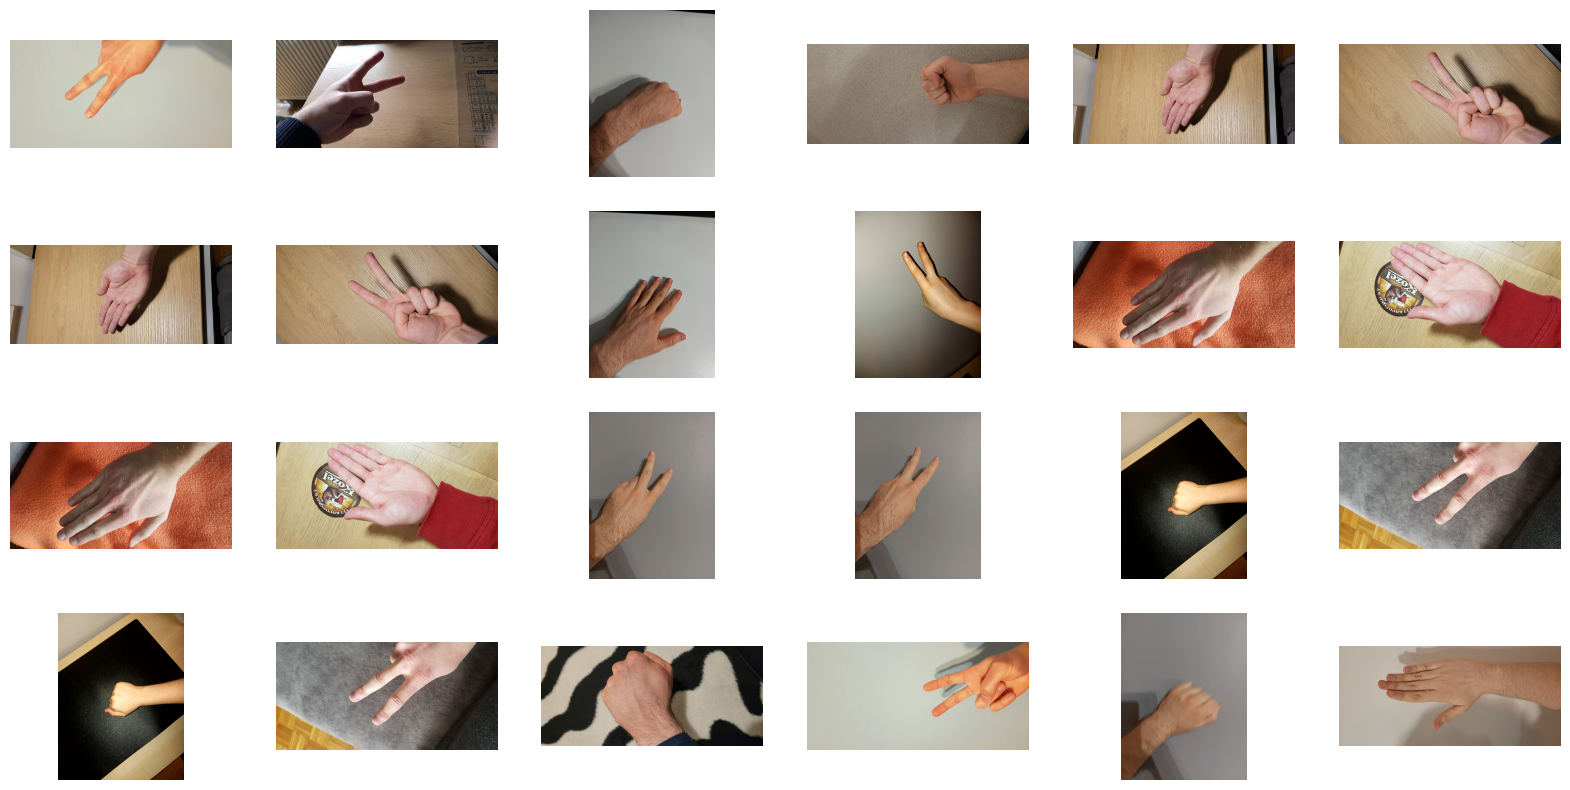

In [10]:
N,M = 4, 6
fig, ax = plt.subplots(N, M, figsize=(20,10))
for i in range(N):
    for j in range(M):
        ax[i,j].imshow(X_raw_custom[N*i + j])
        ax[i,j].axis('off')
plt.show()

In [14]:
best_knn_model_extracted.score(X_custom_extracted, y_custom)

0.48333333333333334

In [16]:
best_decision_tree_model_extracted.score(X_custom_extracted, y_custom)

0.45

In [18]:
best_random_forest_model_extracted.score(X_custom_extracted, y_custom)

0.4666666666666667

In [20]:
best_svm_model_extracted.score(X_custom_extracted, y_custom)

0.575

In [22]:
best_xgboost_model_extracted.score(X_custom_extracted, y_custom)

0.525

### Save models

In [44]:
import pickle

In [45]:
with open('pickled_models/best_knn_model_trained_on_augmented_data.pkl', 'wb') as file:
    pickle.dump(best_knn_model_extracted, file)

In [46]:
with open('pickled_models/best_decision_tree_model_trained_on_augmented_data.pkl', 'wb') as file:
    pickle.dump(best_decision_tree_model_extracted, file)

In [47]:
with open('pickled_models/best_random_forest_model_trained_on_augmented_data.pkl', 'wb') as file:
    pickle.dump(best_random_forest_model_extracted, file)

In [48]:
with open('pickled_models/best_svm_model_trained_on_augmented_data.pkl', 'wb') as file:
    pickle.dump(best_svm_model_extracted, file)

In [49]:
with open('pickled_models/best_xgboost_model_trained_on_augmented_data.pkl', 'wb') as file:
    pickle.dump(best_xgboost_model_extracted, file)

### Test loading models

In [50]:
with open('pickled_models/best_knn_model_trained_on_augmented_data.pkl', 'rb') as file:
    best_knn_model_extracted = pickle.load(file)

best_knn_model_extracted.score(X_custom_extracted, y_custom)

0.48333333333333334

In [51]:
with open('pickled_models/best_decision_tree_model_trained_on_augmented_data.pkl', 'rb') as file:
    best_decision_tree_model_extracted = pickle.load(file)

best_decision_tree_model_extracted.score(X_custom_extracted, y_custom)

0.45

In [52]:
with open('pickled_models/best_random_forest_model_trained_on_augmented_data.pkl', 'rb') as file:
    best_random_forest_model_extracted = pickle.load(file)

best_random_forest_model_extracted.score(X_custom_extracted, y_custom)

0.4666666666666667

In [53]:
with open('pickled_models/best_svm_model_trained_on_augmented_data.pkl', 'rb') as file:
    best_svm_model_extracted = pickle.load(file)

best_svm_model_extracted.score(X_custom_extracted, y_custom)

0.575

In [54]:
with open('pickled_models/best_xgboost_model_trained_on_augmented_data.pkl', 'rb') as file:
    best_xgboost_model_extracted = pickle.load(file)

best_xgboost_model_extracted.score(X_custom_extracted, y_custom)

0.525